### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

In [2]:
data_nights = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv', index_col='date')
data_nights = data_nights.drop('Unnamed: 0', axis=1)
data_nights
nights_PDL = data_nights[['nights_PDL']]
nights_PDL.head()

,nights_PDL
date,
2010-01-01,333.33
2010-02-01,343.87
2010-03-01,446.19
2010-04-01,500.07
2010-05-01,548.92


In [3]:
data_temp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/avgtemp_2010-2017.csv', index_col='date')
data_temp = data_temp.drop('Unnamed: 0', axis=1)
data_temp
avgtemp_PDL = data_temp[['avgtemp_PDL']]
avgtemp_PDL.head()

,avgtemp_PDL
date,
2010-01-01,4.0
2010-02-01,7.0
2010-03-01,8.0
2010-04-01,13.0
2010-05-01,14.0


In [4]:
data_daysoff = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2010-2017.csv', index_col='date')
data_daysoff = data_daysoff.drop('Unnamed: 0', axis=1)
data_daysoff.head()

,daysoff
date,
2010-01-01,11
2010-02-01,9
2010-03-01,9
2010-04-01,10
2010-05-01,12


In [5]:
data_gdp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/regionalGDP_2010-2015.csv', index_col='date')
data_gdp = data_gdp.drop('Unnamed: 0', axis=1)
data_gdp
gdp_PDL = data_gdp[['gdp_PDL']]
gdp_PDL.head()

,gdp_PDL
date,
2010-01-01,96709.073745
2010-02-01,96709.073745
2010-03-01,96709.073745
2010-04-01,96709.073745
2010-05-01,96709.073745


In [6]:
data_PDL = pd.concat([nights_PDL, avgtemp_PDL, data_daysoff, gdp_PDL], axis=1, sort=False)
data_PDL.index = pd.to_datetime(data_PDL.index)
data_PDL_train = data_PDL.dropna(axis=0, how='any')
print(data_PDL_train.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2010-01-01 to 2015-12-01
Data columns (total 4 columns):
nights_PDL     72 non-null float64
avgtemp_PDL    72 non-null float64
daysoff        72 non-null int64
gdp_PDL        72 non-null float64
dtypes: float64(3), int64(1)
memory usage: 2.8 KB
None


### Stationarity check

In [7]:
from statsmodels.tsa.stattools import adfuller

for column in data_PDL_train.columns:
    result = adfuller(data_PDL_train[column])
#     print(f'Stationarity test for variable {column}')
#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f' % result[1])
#     print('Critical Values:')

#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value))
    
    if result[1] < 0.05:
        print('STATIONARY')
        print(f'{column}')
        print('-------')
    else:
        print('NON-STATIONARY')
        print(f'{column}')
        print('-------')

NON-STATIONARY
nights_PDL
-------
NON-STATIONARY
avgtemp_PDL
-------
STATIONARY
daysoff
-------
NON-STATIONARY
gdp_PDL
-------


Result:
- Nights, AvgTemp, GDP are all non-stationary
- Daysoff is stationary

#### Figure out which series' seasonality is additive or multiplicative

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# ----- Additive Model below -----

add_data = seasonal_decompose(data_PDL_train, model='additive')  

add_trend = add_data.trend.dropna()
add_seasonal = add_data.seasonal.dropna()
add_residual = add_data.resid.dropna()

# stationarity_test(add_residual)

# ----- Multiplicative Model below -----

mult_data = seasonal_decompose(data_PDL_train, model='multiplicative')  

mult_trend = mult_data.trend.dropna()
mult_seasonal = mult_data.seasonal.dropna()
mult_residual = mult_data.resid.dropna()

# stationarity_test(mult_residual)

In [9]:
from statsmodels.tsa.stattools import acf

add_acfs = add_residual.apply(acf, axis=0).apply(np.square, axis=0).apply(np.sum)

mult_acfs = mult_residual.apply(acf, axis=0).apply(np.square, axis=0).apply(np.sum)

additive = add_acfs < mult_acfs
add_cols = additive.index[additive].tolist()
mult_cols = additive.index[~additive].tolist()
print('Additive:', add_cols)
print('Multiplicative', mult_cols)

Additive: ['nights_PDL', 'daysoff']
Multiplicative ['avgtemp_PDL', 'gdp_PDL']


- Nights in PDL is an additive time series

### Forecasting the 3 parts: Seasonal, Trend, and Residuals

#### Seasonal forecasts for 2016 (nights only)
- Seasonal naive forecast method: Taking the same seasonal data as 2015

In [10]:
add_seasonal.tail()

,nights_PDL,avgtemp_PDL,daysoff,gdp_PDL
2015-08-01,250.886396,6.559028,0.477778,-326.448156
2015-09-01,90.760729,5.134028,-0.713889,-544.080261
2015-10-01,-21.386437,2.292361,-0.313889,-761.712365
2015-11-01,-112.081854,-2.349306,0.269444,-979.344469
2015-12-01,-169.870854,-5.790972,0.052778,-1196.976573


In [45]:
add_seasonal_2016 = add_seasonal[(add_seasonal.index>='2015-01-01')&(add_seasonal.index<'2016-01-01')]
add_seasonal_2016.head()

,nights_PDL,avgtemp_PDL,daysoff,gdp_PDL
2015-01-01,-169.663271,-6.015972,-0.538889,1196.976573
2015-02-01,-153.071438,-7.049306,-1.338889,979.344469
2015-03-01,-83.517437,-3.674306,-0.147222,761.712365
2015-04-01,-10.023021,-1.490972,0.061111,544.080261
2015-05-01,48.813063,1.050694,1.869444,326.448156


#### Trend forecasts for 2016 (nights only)
- non-seasonal forecasting methods ex. ARIMA or Holt's

In [12]:
add_trend.head()

,nights_PDL,avgtemp_PDL,daysoff,gdp_PDL
2010-07-01,504.730833,12.875000,9.875000,96928.545025
2010-08-01,507.301667,13.125000,9.833333,97367.487585
2010-09-01,508.576667,13.375000,9.833333,97806.430145
2010-10-01,510.222917,13.583333,9.875000,98245.372705
2010-11-01,512.534167,13.750000,9.791667,98684.315265


In [13]:
from pyramid.arima import auto_arima
arima_trend = auto_arima(np.array(add_trend.nights_PDL), start_p=0, start_q=0, max_p=20, max_q=20, m=12,
                    start_P=0, max_P=20, seasonal=False, d=1, D=1, trace=True,
                    error_action='ignore', suppress_warnings=True, stepwise=False, random=True, random_state=42) 

arima_trend.summary()

Fit ARIMA: order=(6, 1, 3); AIC=189.030, BIC=211.883, Fit time=0.739 seconds
Fit ARIMA: order=(8, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=242.666, BIC=246.821, Fit time=0.003 seconds
Fit ARIMA: order=(5, 1, 0); AIC=197.106, BIC=211.649, Fit time=0.133 seconds
Fit ARIMA: order=(0, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(9, 1, 0); AIC=194.071, BIC=216.924, Fit time=0.849 seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=204.095, BIC=212.405, Fit time=0.047 seconds
Fit ARIMA: order=(10, 1, 0); AIC=195.575, BIC=220.505, Fit time=1.330 seconds
Fit ARIMA: order=(3, 1, 0); AIC=199.633, BIC=210.020, Fit time=0.063 seconds
Total fit time: 3.200 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   59
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -83.515
Method:                       css-mle   S.D. of innovations              0.916
Date:                Sun, 19 Aug 2018   AIC                            189.030
Time:                        16:34:02   BIC                            211.883
Sample:                             1   HQIC                           197.951
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8525      0.590      1.445      0.155      -0.304       2.009
ar.L1.D.y      0.6516      0.147      4.442      0.000       0.364       0.939
ar.L2.D.y     -0.3874      0.155     -2.496      0.016      -0.692      -0.083
ar.L3.D.y      0.1351      0.162      0.834      0.408      -0.182       0.453
ar.L4.D.y      0.0977      0.167      0.587      0.560      -0.229       0.424
ar.L5.D.y      0.2156      0.166      1.300      0.200      -0.109       0.540
ar.L6.D.y     -0.1601      0.134     -1.192      0.239      -0.423       0.103
ma.L1.D.y      0.1595      0.125      1.277      0.208      -0.085       0.404
ma.L2.D.y      0.1595      0.129      1.234      0.223      -0.094       0.413
ma.L3.D.y      1.0000      0.136      7.356      0.000       0.734       1.266
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1143           -0.9141j            1.4413           -0.3907
AR.2           -1.1143           +0.9141j            1.4413            0.3907
AR.3            0.2743           -1.1027j            1.1363           -0.2112
AR.4            0.2743           +1.1027j            1.1363            0.2112
AR.5            1.5132           -0.1972j            1.5260           -0.0206
AR.6            1.5132           +0.1972j            1.5260            0.0206
MA.1           -1.0000           -0.0000j            1.0000           -0.5000
MA.2            0.4202           -0.9074j            1.0000           -0.1810
MA.3            0.4202           +0.9074j            1.0000            0.1810
-----------------------------------------------------------------------------
"""

In [14]:
arima_trend.fit(add_trend.nights_PDL)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(6, 1, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [15]:
arima_trend_forecast_2016 = arima_trend.predict(n_periods=12)
arima_trend_forecast_2016

array([552.93234163, 554.07130367, 555.28330746, 556.43649955,
       557.45387436, 558.416607  , 559.29496733, 560.20489308,
       561.12304384, 561.99772609, 562.84688727, 563.69101429])

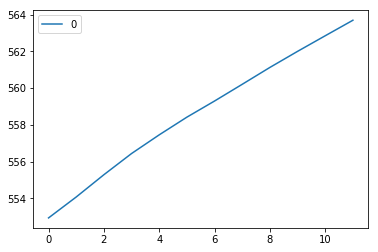

In [16]:
arima_trend_forecast_2016_df = pd.DataFrame(arima_trend_forecast_2016)
arima_trend_forecast_2016_df.plot()

#### Residual forecasts for 2016 (produces forecasts for all but we will use nights forecast only)
- VAR model
- Takes all variables into account and gives predictions for all
- We will be taking the VAR prediction for nights_PDL only

In [18]:
add_residual.head()

,nights_PDL,avgtemp_PDL,daysoff,gdp_PDL
2010-07-01,-2.689646,2.324306,0.863889,-110.655228
2010-08-01,-21.918062,0.315972,-1.311111,-331.965683
2010-09-01,-4.777396,-0.509028,-0.119444,-553.276139
2010-10-01,-12.196479,-1.875694,1.438889,-774.586595
2010-11-01,-2.692312,-1.400694,-0.061111,-995.897050


In [46]:
from statsmodels.tsa.api import VAR

model = VAR(add_residual, dates=add_residual.index)

# lagorder_results = model.select_order(11)
# print(lagorder_results.summary())

results = model.fit(maxlags=11, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 19, Aug, 2018
Time:                     20:39:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    15.8131
Nobs:                     49.0000    HQIC:                   11.5002
Log likelihood:          -315.268    FPE:                1.38967e+06
AIC:                      8.86352    Det(Omega_mle):         102609.
--------------------------------------------------------------------
Results for equation nights_PDL
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -1.107250         1.447653           -0.765           0.444
L1.nights_PDL          -0.247908         0.232093           -1.068           0.285
L1.avgtemp_PDL         -5.859544         3.1162

/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [49]:
lag_order = results.k_ar
print(lag_order)

add_resid_forecast_2016 = results.forecast(add_residual.values[-lag_order:], 12)
add_resid_forecast_2016

11


array([[-2.13527003e+01,  3.46653587e+00, -1.78726382e-01,
         2.05638642e+00],
       [-4.94076522e+00, -6.91558965e-01,  7.44802827e-01,
        -7.69857825e+02],
       [-2.85962325e+01, -3.95207986e+00, -1.06008602e-01,
        -6.90531052e+02],
       [-1.90055702e+01, -7.00543567e-02,  5.06168512e-01,
        -8.15876215e+02],
       [-2.89229431e+01, -1.35111436e+00,  2.30521789e-01,
        -1.44445250e+03],
       [-1.61726214e+01, -3.86609628e+00, -8.74181223e-01,
        -1.41104960e+03],
       [-1.25425143e+01,  7.87975738e-02,  7.69174357e-01,
         3.33911608e+02],
       [-1.76106545e+01,  2.25287265e+00,  1.07700992e-01,
        -1.43781131e+02],
       [-3.09715399e+01, -9.41289575e-01, -5.16862712e-01,
        -7.42360019e+02],
       [-8.82348710e+00, -2.14896270e-01,  9.29687178e-01,
        -5.92652501e+02],
       [-4.45704471e+01, -1.12806696e+00, -3.52084002e-01,
        -8.76922593e+02],
       [ 4.32571973e+00, -2.95928177e+00, -2.58205743e-01,
      

In [47]:
add_resid_forecast_2016_df = pd.DataFrame(add_resid_forecast_2016)
add_resid_forecast_2016_df.head()

,0,1,2,3
0,-21.352700,3.466536,-0.178726,2.056386
1,-4.940765,-0.691559,0.744803,-769.857825
2,-28.596232,-3.952080,-0.106009,-690.531052
3,-19.005570,-0.070054,0.506169,-815.876215
4,-28.922943,-1.351114,0.230522,-1444.452503


#### Putting the decomposed forecasts back together (additive; nights only)


In [48]:
add_seasonal_2016_array = add_seasonal_2016.nights_PDL.values
add_seasonal_2016_df = pd.DataFrame(add_seasonal_2016_array)
add_seasonal_2016_df.head(2)


,0
0,-169.663271
1,-153.071438


### 2016 Nights forecast


In [23]:
forecast_2016 = add_seasonal_2016_df[0] + (arima_trend_forecast_2016_df[0] + add_resid_forecast_2016_df[0])
forecast_2016

0     361.916371
1     396.059101
2     443.169637
3     527.407909
4     577.343994
5     699.659298
6     718.491266
7     793.480634
8     620.912233
9     531.787801
10    406.194586
11    398.145880
Name: 0, dtype: float64

#### Actual values for 2016

In [24]:
nights_PDL_2016 = data_PDL[(data_PDL.index>='2016-01-01')&(data_PDL.index<'2017-01-01')]
nights_PDL_2016 = np.array(nights_PDL_2016.nights_PDL)
nights_PDL_2016_df = pd.DataFrame(nights_PDL_2016)
nights_PDL_2016_df

,0
0,369.21
1,411.32
2,509.15
3,580.11
4,645.10
5,715.97
6,825.06
7,872.86
8,677.11
9,575.70


### Compare with real number of nights in 2016

#### AIC for 2016 forecast

In [25]:
results.aic

8.863517342459701

#### MASE for 2016 forecast

In [26]:
# Define seasonality as 12 (monthly data) in argument when ground truth data includes at least 24 months

def seasonal_MASE(truth, forecast, seasonality=1):    
    period = truth.shape[0] # T
    # print(period)
    forecast_errors = np.abs(truth - forecast)
    # print(forecast_errors)
    mean_absolute_forecast_error = np.sum(forecast_errors) / period
    # print(mean_absolute_forecast_error)

    naive_period = truth.shape[0] - seasonality # T - m
    # print(naive_period)
    # print(truth[seasonality:])
    # print(truth[:period - seasonality])
    naive_errors = np.abs(truth[seasonality:] - truth[:period - seasonality])
    mean_absolute_naive_error = np.sum(naive_errors) / naive_period
    
    return mean_absolute_forecast_error / mean_absolute_naive_error

**MASE for our 2016 forecast** tells us that the error of our model is 54% of the seasonal naive model's error
> This means more than half of the seasonal naive model's error

In [27]:
MASE_2016 = seasonal_MASE(nights_PDL_2016, forecast_2016)
print('MASE: %f' % MASE_2016)

MASE: 0.547148


In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_2016 = np.sqrt(mean_squared_error(nights_PDL_2016, forecast_2016))
mae_2016 = mean_absolute_error(nights_PDL_2016, forecast_2016)
print('RMSE:', rmse_2016)
print('MAE:', mae_2016)


RMSE: 56.58625005500477
MAE: 48.196774183177716


#### Predictions vs. Ground truth for Hotel nights PAC 2016

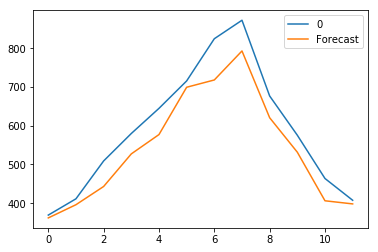

In [29]:
nights_PDL_2016_df.plot(label='Real')
forecast_2016.plot(label='Forecast')
plt.legend()

### Extra - 2017 forecast comparison

In [30]:
add_resid_forecast_2017 = results.forecast(add_residual.values[-lag_order:], 24)
add_resid_forecast_2017_df = pd.DataFrame(add_resid_forecast_2017)
add_resid_forecast_2017_df.head()

,0,1,2,3
0,-21.352700,3.466536,-0.178726,2.056386
1,-4.940765,-0.691559,0.744803,-769.857825
2,-28.596232,-3.952080,-0.106009,-690.531052
3,-19.005570,-0.070054,0.506169,-815.876215
4,-28.922943,-1.351114,0.230522,-1444.452503


In [31]:
arima_trend_forecast_2017 = arima_trend.predict(n_periods=24)
arima_trend_forecast_2017_df = pd.DataFrame(arima_trend_forecast_2017)
arima_trend_forecast_2017_df.head()

,0
0,552.932342
1,554.071304
2,555.283307
3,556.436500
4,557.453874


In [32]:
nights_PDL_2017 = data_PDL[(data_PDL.index>='2017-01-01')&(data_PDL.index<'2017-12-02')]
nights_PDL_2017 = np.array(nights_PDL_2017.nights_PDL)
nights_PDL_2017_df = pd.DataFrame(nights_PDL_2017)
nights_PDL_2017_df.head()

,0
0,388.64
1,401.30
2,491.17
3,636.35
4,634.84


In [36]:
nights_resid_2017 = add_resid_forecast_2017_df[0][12:24]
forecast_2017 = add_seasonal_2016_df[0].values + arima_trend_forecast_2017_df[12:24].values.transpose()[0] + nights_resid_2017.values.transpose()
forecast_2017_df = pd.Series(forecast_2017.transpose())
forecast_2017_df

0     361.624719
1     331.289824
2     453.458678
3     546.215745
4     527.160342
5     687.770321
6     714.282713
7     774.472929
8     624.272981
9     499.451549
10    362.895845
11    335.066479
dtype: float64

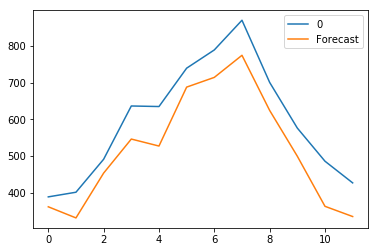

In [37]:
nights_PDL_2017_df.plot(label='Real')
forecast_2017_df.plot(label='Forecast')
plt.legend()

In [44]:
MASE_2017 = seasonal_MASE(nights_PDL_2017, forecast_2017)
print('MASE:', MASE_2017)

MASE: 0.9113186799658684


In [41]:
rmse_2017 = np.sqrt(mean_squared_error(nights_PDL_2017, forecast_2017))
mae_2017 = mean_absolute_error(nights_PDL_2017, forecast_2017)
print('RMSE:', rmse_2017)
print('MAE:', mae_2017)

RMSE: 81.34349328382083
MAE: 76.85398969610338
